# MUST RUN AT THE START OF EVERYTHING

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession
session = SnorkelSession()

# Parse the Pubmed Abstracts

In [2]:
from snorkel.parser import XMLMultiDocParser

xml_parser = XMLMultiDocParser(
    path='data/Epilepsy/epilepsy_training.xml',
    doc='.//document',
    text='.//passage/text/text()',
    id='.//id/text()')

In [3]:
from epilepsy_utils import Tagger
from snorkel.parser import SentenceParser

dg_tagger = Tagger()
sent_parser = SentenceParser(fn=dg_tagger.tag)

[========================================] 100%%

Number of documents: 2500
CPU times: user 42.1 s, sys: 696 ms, total: 42.8 s
Wall time: 7min 15s


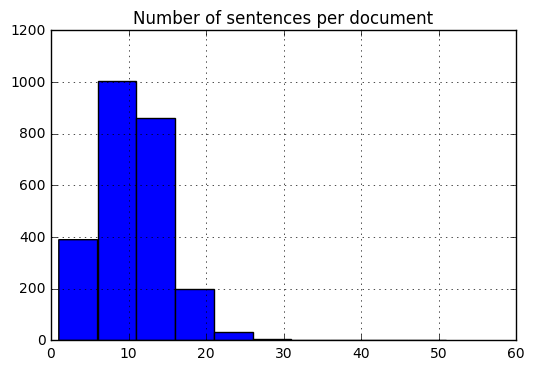

In [4]:
from snorkel.parser import CorpusParser

cp = CorpusParser(xml_parser, sent_parser, max_docs=5000)
%time corpus = cp.parse_corpus(name='Epilepsy Train', session=session)
session.add(corpus)
session.commit()

In [6]:
from snorkel.parser import XMLMultiDocParser

xml_parser = XMLMultiDocParser(
    path='data/Epilepsy/epilepsy_testing.xml',
    doc='.//document',
    text='.//passage/text/text()',
    id='.//id/text()')

[========================================] 100%%

Number of documents: 1000
CPU times: user 15.9 s, sys: 192 ms, total: 16.1 s
Wall time: 2min 43s


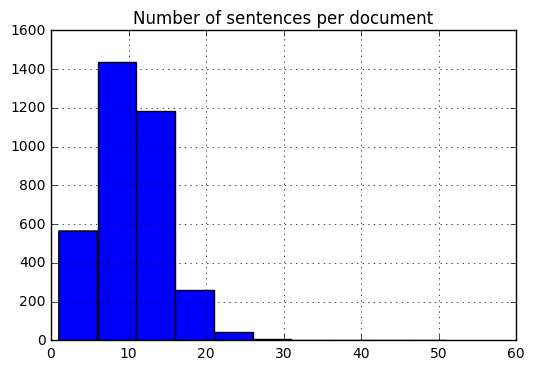

In [7]:
from snorkel.parser import CorpusParser

cp = CorpusParser(xml_parser, sent_parser, max_docs=5000)
%time corpus = cp.parse_corpus(name='Epilepsy Test', session=session)
session.add(corpus)
session.commit()

# Get each candidate relation

In [9]:
from snorkel.models import candidate_subclass

DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])

In [10]:
from snorkel.candidates import PretaggedCandidateExtractor

ce = PretaggedCandidateExtractor(DiseaseGene, ['Disease', 'Gene'])

In [11]:
from snorkel.models import Corpus
for corpus_name in ["Epilepsy Train","Epilepsy Test"]:
    corpus = session.query(Corpus).filter(Corpus.name == corpus_name).one()
    sentences = set()
    for document in corpus:
        for sentence in document.sentences:
            sentences.add(sentence)
    %time c = ce.extract(sentences, corpus_name +" Candidates",session)
    print '{0} has {1} candidates'.format(corpus_name, len(c))
    session.add(c)
session.commit()

[========================================] 100%

CPU times: user 1min, sys: 220 ms, total: 1min
Wall time: 1min 1s
Epilepsy Train has 7376 candidates
[========================================] 100%

CPU times: user 21.9 s, sys: 108 ms, total: 22 s
Wall time: 22.5 s
Epilepsy Test has 2548 candidates


# Get all the Features

In [12]:
from snorkel.models import CandidateSet
from snorkel.annotations import FeatureManager

feature_manager = FeatureManager()
train = session.query(CandidateSet).filter(CandidateSet.name == 'Epilepsy Train Candidates').one()
test = session.query(CandidateSet).filter(CandidateSet.name == 'Epilepsy Test Candidates').one()

In [ ]:
#Check out the list of candidates and manually annotate the candidates
#from snorkel.viewer import SentenceNgramViewer

#view = SentenceNgramViewer(train,session)
#view

In [15]:
%time F_train = feature_manager.create(session, train, 'Train Features')
%time F_test = feature_manager.update(session,test,'Train Features',False)

[========================================] 100%

Loading sparse Feature matrix...
CPU times: user 11min 2s, sys: 1.16 s, total: 11min 3s
Wall time: 11min 4s
[========================================] 100%

Loading sparse Feature matrix...
CPU times: user 2min 29s, sys: 324 ms, total: 2min 29s
Wall time: 2min 29s


# Label Functions for the label manager

In [16]:
import re
from snorkel.lf_helpers import (
    get_left_tokens,
    get_right_tokens, 
    get_between_tokens,
    get_tagged_text,
    get_text_between,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

In [17]:
#insert label functions here!!!
#For my hackish debugger purposes only
def LF_debugger(c):
    print c
    print
    print vars(c)
    print
    print vars(c[0])
    print
    print c[0]
    print 
    print c[0].get_span()
    print
    print get_tagged_text(c)
    print
    print get_text_between(c)
    print
    print get_between_tokens(c)
    print
    print get_left_tokens(c)
    print
    print get_right_tokens(c)
    print
    sys.exit(1)
    return 1 if c else 0

def LF_between_tag(c):
    m = re.search("associated with|Disruption",get_text_between(c))
    return 1 if m else 0

def LF_mutation(c):
    m = re.search("mutation", ",".join(get_left_tokens(c)))
    n = re.search("mutation", ",".join(get_right_tokens(c)))
    return 1 if m or n else 0

def LF_check_disease_tag(c):
    disease_name = c[0].get_span()
    if "syndrome" in disease_name:
        if "epilepsy" in disease_name.replace("syndrome",""):
            return 1
        else:
            return -1
    else:
        return 1 if "epilepsy" in disease_name else 0

In [18]:
LFs = [
    #LF_debugger
    LF_between_tag,
    LF_mutation,
    LF_check_disease_tag,
]

# Label the candidates below

In [20]:
from snorkel.annotations import LabelManager
label_manager = LabelManager()

%time L_train = label_manager.create(session, train, 'LF Train Labels', f=LFs)
%time L_test = label_manager.create(session, test, 'LF Test Labels', f=LFs)
L_train
L_test

[========================================] 100%

Loading sparse Label matrix...
CPU times: user 32.5 s, sys: 68 ms, total: 32.6 s
Wall time: 32.9 s
[========================================] 100%

Loading sparse Label matrix...
CPU times: user 11.1 s, sys: 56 ms, total: 11.1 s
Wall time: 11.3 s


<2548x3 sparse matrix of type '<type 'numpy.float64'>'
	with 1301 stored elements in Compressed Sparse Row format>

# Genreate Coverage Stats

In [22]:
print L_train.lf_stats()
print L_test.lf_stats()

                      j  coverage  overlaps  conflicts
LF_between_tag        0  0.078362  0.033080   0.013422
LF_mutation           1  0.132592  0.048400   0.021150
LF_check_disease_tag  2  0.274132  0.066161   0.032674
                      j  coverage  overlaps  conflicts
LF_between_tag        0  0.104788  0.036107   0.010989
LF_mutation           1  0.148744  0.052983   0.027865
LF_check_disease_tag  2  0.257064  0.070251   0.037677


# Load preprocessed data 

In [ ]:
from snorkel.models import candidate_subclass

DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])

In [ ]:
#If you didn't run the cells above load the data here
from snorkel.models import CandidateSet
from snorkel.annotations import FeatureManager

feature_manager = FeatureManager()
train = session.query(CandidateSet).filter(CandidateSet.name == 'Epilepsy Train Candidates').one()
test = session.query(CandidateSet).filter(CandidateSet.name == 'Epilepsy Test Candidates').one()

In [ ]:
#Only run if you didn't run the cells above
from snorkel.annotations import FeatureManager
feature_manager = FeatureManager()
%time F_train = feature_manager.load(session, train, 'Train Features')
%time F_test = feature_manager.load(session,test,'Train Features')

In [ ]:
from snorkel.annotations import LabelManager
label_manager = LabelManager()

L_train = label_manager.load(session,train,'LF Train Labels')
L_test = label_manager.load(session,train,'LF Test Labels')

# Run the machine learning models below

In [23]:
#Train the model
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
gen_model.train(L_train)
train_marginals = gen_model.marginals(L_train)
gen_model.save(session,"First Gen Model")

/home/davidnicholson/anaconda3/envs/snorkeling/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Training marginals (!= 0.5):	7376
Features:			3
Begin training for rate=0.01, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.028778
	Learning epoch = 250	Gradient mag. = 0.028347
	Learning epoch = 500	Gradient mag. = 0.026948
	Learning epoch = 750	Gradient mag. = 0.025977
Final gradient magnitude for rate=0.01, mu=1e-06: 0.025


In [24]:
train_marginals

array([ 0.5       ,  0.67603679,  0.5       , ...,  0.74292153,
        0.74292153,  0.74292153])

In [25]:
from snorkel.learning import LogReg

disc_model = LogReg()
disc_model.train(F_train, train_marginals, n_iter=5000, rate=1e-3)
disc_model.save(session,"First Model")

Training marginals (!= 0.5):	3022
Features:			103780
Using gradient descent...
	Learning epoch = 0	Step size = 0.001
	Loss = 2094.690780	Gradient magnitude = 709.661750
	Learning epoch = 100	Step size = 0.000904792147114
	Loss = 1820.403300	Gradient magnitude = 58.384926
	Learning epoch = 200	Step size = 0.000818648829479
	Loss = 1808.769871	Gradient magnitude = 8.763705
	Learning epoch = 300	Step size = 0.000740707032156
	Loss = 1804.478272	Gradient magnitude = 6.403146
	Learning epoch = 400	Step size = 0.000670185906007
	Loss = 1802.225522	Gradient magnitude = 5.127766
	Learning epoch = 500	Step size = 0.000606378944861
	Loss = 1800.859906	Gradient magnitude = 4.331352
	Learning epoch = 600	Step size = 0.000548646907485
	Loss = 1799.956538	Gradient magnitude = 3.790521
	Learning epoch = 700	Step size = 0.000496411413431
	Loss = 1799.322196	Gradient magnitude = 3.402592
	Learning epoch = 800	Step size = 0.00044914914861
	Loss = 1798.857356	Gradient magnitude = 3.113730
	Learning epoch

Scores (Un-adjusted)
Pos. class accuracy: 0.978
Neg. class accuracy: 0.329
Precision            0.146
Recall               0.978
F1                   0.254
----------------------------------------
TP: 261 | FP: 1530 | TN: 751 | FN: 6


Calibration plot:


/home/davidnicholson/anaconda3/envs/snorkeling/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


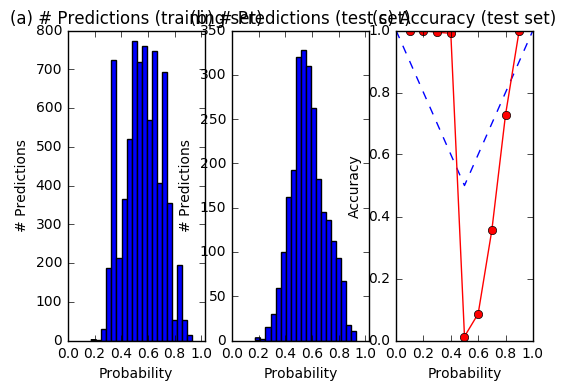

In [26]:
# This is cool.
# The output for the score function will give me the candiates and their corresponding categories:
# TP, FP, TN, FN
tp,fp,tn,fn = disc_model.score(F_test,L_test)

In [34]:
# For each candidate output the given prediction
# Now this will work!!!
candidates = [F_test.get_candidate(c) for c in range(F_test.shape[0])]
predictions = disc_model.predict(F_test)
print zip(candidates,predictions)
#print F_test.get_candidate(1).context.id
#print F_test.get_candidate(1)
#
#vars(list(tp)[0][0].parent)

[(DiseaseGene(Span("congenital hyperinsulinism", parent=35786, chars=[74,99], words=[11,12]), Span("somatostatin", parent=35786, chars=[15,26], words=[3,3])), -1), (DiseaseGene(Span("Seizure", parent=35786, chars=[0,6], words=[0,0]), Span("somatostatin", parent=35786, chars=[15,26], words=[3,3])), 1), (DiseaseGene(Span("congenital hyperinsulinism", parent=35788, chars=[22,47], words=[5,6]), Span("ABCC8", parent=35788, chars=[133,137], words=[24,24])), -1), (DiseaseGene(Span("congenital hyperinsulinism", parent=35788, chars=[22,47], words=[5,6]), Span("SUR1", parent=35788, chars=[153,156], words=[27,27])), -1), (DiseaseGene(Span("congenital hyperinsulinism", parent=35788, chars=[22,47], words=[5,6]), Span("somatostatin", parent=35788, chars=[169,180], words=[30,30])), -1), (DiseaseGene(Span("seizures", parent=35788, chars=[247,254], words=[39,39]), Span("ABCC8", parent=35788, chars=[133,137], words=[24,24])), -1), (DiseaseGene(Span("seizures", parent=35788, chars=[247,254], words=[39,39

In [27]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    sv = SentenceNgramViewer(tp, session, annotator_name="Tutorial Part V 2User")
else:
    sv = None

<IPython.core.display.Javascript object>

In [28]:
sv